# Return Correlations
This notebook is for the next phase of our risk project, assessing the correlation of various stocks' _returns_ over different timeframes. In particular, we want to look at correlations of _weekly returns_ between _each pair_ of companies for _6-month periods._  
We'll probably have to re-collect the WRDS data, since we never saved the weekly returns anywhere. This could take a minute.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import wrds
import pandas_market_calendars as mcal
from datetime import date, timedelta, datetime
import matplotlib.pyplot as plt
from IPython.display import clear_output
conn = wrds.Connection(wrds_username='kaihvc')

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Loading library list...
Done


## Data collection
The following cells re-collect daily return data from the WRDS database and calculate weekly returns from it. It takes about 50 minutes to make the database request and save the file, so it's better just to read the dataframe from disk at `wrds_results/weekly_rets.csv` after the first time.

In [2]:
# setup for wrds data
def get_days(start_dt, end_dt):
    nyse = mcal.get_calendar('NYSE')
    return [day.date() for day in nyse.valid_days(start_date=str(start_dt), 
                                                end_date=str(end_dt))]

def get_weeks(start_dt, end_dt):
    weeks = []

    # get trading days and divide into weeks, rolling over on the given rollover day
    current_week = []
    days = get_days(start_dt, end_dt)
    for i, day in enumerate(days):
        # append to current week
        current_week.append(day)

        #end of the week check
        if i+1<len(days):
            next_day = days[i+1]
            if next_day.weekday() < day.weekday(): #if the next day's weekday comes before the current, then the next_day is in a new week
                weeks.append(current_week)
                current_week = []
            elif (next_day-day).days > 4: #if the condition above didnt pass, check that >4 days didnt pass as well
                weeks.append(current_week)
                current_week = []

    # append final week, even if it wasn't a full week period
    if current_week: weeks.append(current_week)

    return weeks

def get_periods(weeks):
    periods = []
    start_date = weeks[0][0]
    end_date = None
    for i in range(len(weeks)-1):
        start = weeks[i][0] #this monday
        end = weeks[i][-1]  #this friday

        next_start = weeks[i+1][0] #next monday
        next_end = weeks[i+1][-1]  #next friday

        #if the current friday is in december, and the next weeks friday is in january, this is the end of one period
        #the very next week will be the very start of the period\
        if end.month == 12 and next_end.month == 1:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
        #if the last day is in june, and the next weeks last day is in july, this is the end of one period
        #the very next week will be the very start of the period
        if end.month == 6 and next_end.month == 7:
            end_date = end
            periods.append([start_date,end_date])
            start_date = next_start
    periods.append([start_date, weeks[i+1][-1]])
    for i in periods:
        i[1] += timedelta(days=3)
    return periods

def periodToStr(period):
    return period[0].strftime("%m/%d/%Y") + " - " + period[1].strftime("%m/%d/%Y")

# initialize company list
companies = conn.get_table(library='crsp', table='stocknames')

In [3]:
# WRDS database request & processing
# get daily returns
def get_returns(start_dt, end_dt, username='kaihvc', min_market_cap=10000):
    conn = wrds.Connection(wrds_username=username)
    query = f"SELECT cusip, date, ret FROM crsp.dsf WHERE date>='{str(start_dt)}' AND date<='{str(end_dt)}' AND prc*shrout>={min_market_cap}"
    df = conn.raw_sql(query)
    return df

# process daily returns into weekly
# unused - takes AGES
def process_returns(df, start_dt, end_dt):
    
    weekly_master = []
    weeks = get_weeks(start_dt, end_dt)
    wk_starts = [week[0] for week in weeks]
    
    for cusip in df['cusip'].unique():
        
        cusip_df = df[df['cusip'] == cusip]
        
        # create weekly ret & std dataframes
        weekly_returns = pd.DataFrame(index=pd.MultiIndex.from_product([[cusip], wk_starts]), 
                                                          columns=['return'])

        # separate into weeks
        for week in weeks:

            # if daily data exists for this stock for this week, calculate returns
            day_indices = cusip_df['date'].isin(week)
            if np.any(day_indices):

                # overall weekly return calculation
                daily_rets = cusip_df['ret'].loc[day_indices]
                weekly_ret = np.product([1 + ret for ret in daily_rets]) - 1
                weekly_returns.loc[(cusip, week[0]), 'return'] = weekly_ret
        
        weekly_master.append(weekly_returns)
        
    return pd.concat(weekly_master)

# TODO: test for accuracy
def pd_process_weekly(df, start_dt, end_dt):
    
    # takes ~25-30 min all told; most spent on the aggregation
    df['date'] = pd.to_datetime(df['date'])
    grouper = pd.Grouper(key='date', freq='W-MON')
    grouped = df.groupby(by=['cusip', grouper], observed=True)
    weekly_rets = grouped.agg({'ret': lambda x: (x + 1).product() - 1})
    
    # try this if we need x valid days to make a valid week
#     count_mask = grouped.count() > 3
#     return weekly_rets[count_mask]
    
    return weekly_rets

In [4]:
# parameters
start_dt = date(1950, 1, 1)
end_dt = date(2021, 1, 1)

# get returns
recalc = False
if recalc:
    exec_start = datetime.now()
    daily_rets = get_returns(start_dt, end_dt)
    weekly_rets = pd_process_weekly(daily_rets, start_dt, end_dt)
    weekly_rets.to_csv('wrds_results/weekly_rets.csv')
    print(f'Weekly returns downloaded in {str(datetime.now() - exec_start)}')
else:
    weekly_rets = pd.read_csv('wrds_results/weekly_rets.csv', index_col=[0, 1])
    print('Weekly returns loaded')

c:\users\kaih2\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3417: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Weekly returns loaded


## Calculate 6-month correlations
The following cells calculate return correlations over ~6-month periods from the weekly returns. Note that this generates a correlation matrix _for each period_, so it might take a _while_.

We apply the same filter for each period, requiring it to have at least 20/26 weeks from each period to be included in the correlation matrix. _Only stocks which pass the filter are found in the correlation matrix,_ meaning that it's possible for correlation matrices from different periods to have different sizes (though all will be square).

In [4]:
# get specific dataframe indices for each period cause multiindex slicing is incorrigible
def get_per_idxs(df, periods):
    per_dict = {}
    per_idx = 0
    per = periods[per_idx]
    idx_list = []
    for i, idx in enumerate(df.sort_index(level='date').index):
        if idx[1] < str(per[1]):
            idx_list.append(idx)
        else:
            per_dict[per_idx] = idx_list
            idx_list = []
            per_idx += 1
            if per_idx >= len(periods):
                break
            per = periods[per_idx]
            
    return per_dict

# get correlation matrices for each period
# accepts weekly returns df, start/end dates, and (inclusive) starting period
def get_corrs(df, start_dt, end_dt, start_from=0):
    
    current_iteration = start_from
    periods = get_periods(get_weeks(start_dt, end_dt))
    idx_dict = get_per_idxs(df, periods)
    num_pers = len(periods)

    for i, per in enumerate(periods[start_from:]):
        
        # timing
        iter_start = datetime.now()
        
        # filter for cusips w/ at least 20
        counts = weekly_rets.loc[idx_dict[0]].groupby('cusip').count()
        cusips = counts[counts >= 20].dropna().index
        
        # select data for period, filter out missing data, and unstack to get df of shape (dates, cusips)
        filtered_df = weekly_rets.loc[idx_dict[i]].loc[cusips].unstack(level='cusip')
        filtered_df.columns = filtered_df.columns.droplevel(0)
        
        # calculate correlation matrix & print 
        corr = filtered_df.corr()
        corr.to_csv(f'wrds_results/corr_dump/{str(per[0])}_corr.csv')
        print(f'Period {str(per[0])} complete ({i + start_from + 1}/{num_pers}) in {str(datetime.now() - iter_start)}')
        clear_output(wait=True)

In [108]:
exec_start = datetime.now()
get_corrs(weekly_rets, start_dt, end_dt)
print(f'Period correlations complete in {str(datetime.now() - exec_start)}')

Period correlations complete in 0:08:30.523806


## Concatenating correlations
The following few cells concatenate the calculated correlations into a single multiindexed dataframe. This makes it much easier to manipulate the data for various flexible purposes.

In [5]:
def concatenate_corrs(periods):
    corrs_master = []
    for period in periods:
        idx = period[0]
        
        corr = pd.read_csv(f'wrds_results/corr_dump/{idx}_corr.csv', index_col=0)
        corrs_master.append(corr)
        
        print(f'Period {period[0]} complete')
        
        clear_output(wait=True)
    
    print('Concatenating...')
    return pd.concat(corrs_master, keys=[per[0] for per in periods])

In [6]:
start_dt = date(1950, 1, 1)
end_dt = date(2021, 1, 1)

In [8]:
exec_start = datetime.now()
periods = get_periods(get_weeks(start_dt, end_dt))
all_corrs = concatenate_corrs(periods)
print(f'Done in {str(datetime.now() - exec_start)}')

Concatenating...
Done in 0:00:14.835174


In [9]:
cusips = all_corrs.columns

Index(['780010.0', '2499190.0', '2532110.0', '8199090.0', '11599090.0',
       '16810610.0', '18799090.0', '19728890.0', '23999190.0', '29199090.0',
       ...
       '98199090', '98252610', '98302410', '98389B10', '98499090', '98628590',
       '98771110', '98934910', 'G2918310', 'G8994E10'],
      dtype='object', length=667)

In [10]:
all_corrs

780010.0  2499190.0  2532110.0  8199090.0  11599090.0  \
           cusip                                                               
1950-01-03 780010.0    1.000000  -0.066909   0.404483   0.199195    0.158851   
           2499190.0  -0.066909   1.000000   0.002682   0.349713   -0.125837   
           2532110.0   0.404483   0.002682   1.000000   0.260857    0.048409   
           8199090.0   0.199195   0.349713   0.260857   1.000000   -0.017235   
           11599090.0  0.158851  -0.125837   0.048409  -0.017235    1.000000   
...                         ...        ...        ...        ...         ...   
2020-06-29 93142710    0.358469        NaN        NaN        NaN         NaN   
           96145D10    0.111571        NaN        NaN        NaN         NaN   
           98389B10    0.141734        NaN        NaN        NaN         NaN   
           G2918310    0.248669        NaN        NaN        NaN         NaN   
           G8994E10    0.206186        NaN        NaN        NaN         NaN   

                       16810610.0  18799090.0  19728890.0  23999190.0  \
           cusip                                                        
1950-01-03 780010.0      0.311030    0.222888    0.100573    0.367493   
           2499190.0     0.173368   -0.023259    0.132912   -0.098170   
           2532110.0     0.134616   -0.185508    0.192166    0.223909   
           8199090.0     0.084351    0.305085    0.098585   -0.036184   
           11599090.0    0.467743    0.164516    0.116570    0.342034   
...                           ...         ...         ...         ...   
2020-06-29 93142710           NaN         NaN         NaN         NaN   
           96145D10           NaN         NaN         NaN         NaN   
           98389B10           NaN         NaN         NaN         NaN   
           G2918310           NaN         NaN         NaN         NaN   
           G8994E10           NaN         NaN         NaN         NaN   

                       29199090.0  ...  98199090  98252610  98302410  \
           cusip                   ...                                 
1950-01-03 780010.0      0.123302  ...  0.251752 -0.024616  0.436023   
           2499190.0     0.078377  ... -0.096385  0.130773 -0.032028   
           2532110.0     0.164505  ...  0.661455  0.575518  0.333442   
           8199090.0     0.207171  ...  0.408590  0.386999 -0.031998   
           11599090.0    0.078173  ...  0.268625  0.126235  0.222042   
...                           ...  ...       ...       ...       ...   
2020-06-29 93142710           NaN  ...       NaN       NaN       NaN   
           96145D10           NaN  ...       NaN       NaN       NaN   
           98389B10           NaN  ...       NaN       NaN       NaN   
           G2918310           NaN  ...       NaN       NaN       NaN   
           G8994E10           NaN  ...       NaN       NaN       NaN   

                       98389B10  98499090  98628590  98771110  98934910  \
           cusip                                                          
1950-01-03 780010.0    0.248017  0.260412  0.569278  0.340470  0.027331   
           2499190.0  -0.095968  0.012378  0.011459 -0.038634  0.164649   
           2532110.0   0.090874  0.337636  0.275876  0.578573 -0.184476   
           8199090.0   0.194231  0.467809  0.441363  0.112621 -0.146211   
           11599090.0  0.356992  0.299354  0.142808  0.544927  0.241012   
...                         ...       ...       ...       ...       ...   
2020-06-29 93142710    0.473013       NaN       NaN       NaN       NaN   
           96145D10    0.289118       NaN       NaN       NaN       NaN   
           98389B10    1.000000       NaN       NaN       NaN       NaN   
           G2918310    0.546936       NaN       NaN       NaN       NaN   
           G8994E10    0.648226       NaN       NaN       NaN       NaN   

                       G2918310  G8994E10  
           cusip                           
1950-01-03 780010.0    0.141727

In [15]:
all_corrs.loc[date(1950, 1, 3)]

,780010.0,2499190.0,2532110.0,8199090.0,11599090.0,16810610.0,18799090.0,19728890.0,23999190.0,29199090.0,...,98199090,98252610,98302410,98389B10,98499090,98628590,98771110,98934910,G2918310,G8994E10
cusip,,,,,,,,,,,,,,,,,,,,,
780010.0,1.000000,-0.066909,0.404483,0.199195,0.158851,0.311030,0.222888,0.100573,0.367493,0.123302,...,0.251752,-0.024616,0.436023,0.248017,0.260412,0.569278,0.340470,0.027331,0.141727,0.283331
2499190.0,-0.066909,1.000000,0.002682,0.349713,-0.125837,0.173368,-0.023259,0.132912,-0.098170,0.078377,...,-0.096385,0.130773,-0.032028,-0.095968,0.012378,0.011459,-0.038634,0.164649,0.191438,-0.072424
2532110.0,0.404483,0.002682,1.000000,0.260857,0.048409,0.134616,-0.185508,0.192166,0.223909,0.164505,...,0.661455,0.575518,0.333442,0.090874,0.337636,0.275876,0.578573,-0.184476,-0.055937,0.292780
8199090.0,0.199195,0.349713,0.260857,1.000000,-0.017235,0.084351,0.305085,0.098585,-0.036184,0.207171,...,0.408590,0.386999,-0.031998,0.194231,0.467809,0.441363,0.112621,-0.146211,0.179806,-0.171341
11599090.0,0.158851,-0.125837,0.048409,-0.017235,1.000000,0.467743,0.164516,0.116570,0.342034,0.078173,...,0.268625,0.126235,0.222042,0.356992,0.299354,0.142808,0.544927,0.241012,0.240168,0.063542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98628590,0.569278,0.011459,0.275876,0.441363,0.142808,0.343926,0.209743,0.118153,0.409505,-0.029792,...,0.433314,0.127408,0.383844,0.478683,0.170690,1.000000,0.225312,-0.207982,0.234510,0.124521
98771110,0.340470,-0.038634,0.578573,0.112621,0.544927,0.421505,0.031750,0.184535,0.361949,0.089378,...,0.540612,0.445709,0.347246,0.301312,0.310671,0.225312,1.000000,-0.180945,0.114302,0.374834
98934910,0.027331,0.164649,-0.184476,-0.146211,0.241012,0.130632,-0.038376,0.524346,-0.155344,0.404738,...,-0.272173,-0.192717,0.059384,0.009824,0.048427,-0.207982,-0.180945,1.000000,-0.020292,-0.366479


<AxesSubplot:>

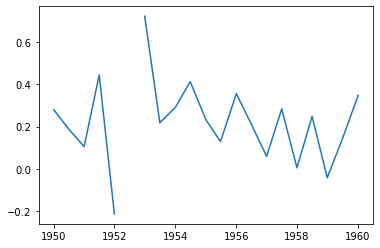

In [16]:
all_corrs.loc[:, '780010.0'].unstack(level='cusip')['00299090'].plot()

TODO
- Transition matrix/heatmap as table (round to ~3 decimals or so), so we have a way to look at the numbers instead of just colors